In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
df = pd.DataFrame.from_csv("rentals.csv")
df = df.drop_duplicates(keep="last")

In [3]:
df_filtered = df.copy()
df_filtered = df_filtered[~df_filtered.index.duplicated(keep='first')]

# Sometimes zest_value_1 contains a rent estimate, other times a value est. Rent estimates end with "/mo"
df_filtered["value_est"] = np.where(df_filtered.zest_value_1.str.contains("^\$?.*[0-9]+ ?$"), 
                                 df_filtered.zest_value_1, 
                                 df_filtered.zest_value_2)

df_filtered["rent_est"] = np.where(df_filtered.zest_value_1.str.contains("^\$?.*/mo ?$"), 
                                 df_filtered.zest_value_1, 
                                 df_filtered.zest_value_2)

# Remove characters and convert to numeric
df_filtered.value_est = df_filtered.value_est.str.replace("$","").str.replace(",","").astype(np.float)
df_filtered.median_zestimate = df_filtered.median_zestimate.str.replace("$","").str.replace(",","").astype(np.float)
df_filtered.rent_est = df_filtered.rent_est.str.replace("$","").str.replace(",","").str.replace("/mo","").astype(np.float)

# Fix sqft and filter out extreme sqft (e.g. sqft listed as acreage vs home size)
df_filtered.sqft = df_filtered.sqft.str.replace("[^0-9]","")
df_filtered.ix[df_filtered.sqft == "", "sqft"] = np.nan
df_filtered.sqft = df_filtered.sqft.astype(np.float)
df_filtered = df_filtered[df_filtered.sqft < 50000]

# Drop NAs
df_filtered = df_filtered.dropna(subset=["value_est"])
df_filtered = df_filtered.dropna(subset=["price"])

# Fill missing sqft with median values from bed-bath combinations
df_filtered.sqft = df_filtered.groupby(["beds","baths"]).transform(lambda x: x.fillna(x.median()))["sqft"]

# Drop anything that doesn't have a sqft comp
df_filtered = df_filtered.dropna(subset=["sqft"])

# Convert zipcode to string
df_filtered["zipcode"] = df_filtered["zipcode"].astype(str).apply(lambda x: x.zfill(5))

# Some sales incorrectly listed as rentals, limit rental price to 10k since some things mislabeled
df_filtered = df_filtered[df_filtered.price < 10000]

# Create new field for rent price to estimated value
df_filtered["rent_to_value"] = df_filtered.price / df_filtered.value_est

# Change school characteristics to numeric
for i in range(1,4):
    field_name = "school_{}_distance".format(i)
    df_filtered[field_name] = df_filtered[field_name].str.replace(" mi", "").astype(np.float)

    field_name = "school_{}_rating".format(i)
    mean_rating = df_filtered[df_filtered[field_name] != "NR"][field_name].astype(np.float).mean()
    df_filtered[field_name] = df_filtered[field_name].str.replace("NR", str(mean_rating)).astype(np.float)


In [4]:
# Everything looks in order...

df_filtered.iloc[0]

Additional Features    Appliances \ Range hood;BedroomMaster1Level \ ...
Appliances Included               Dryer;Range / Oven;Refrigerator;Washer
Construction           Exterior material: Brick, Vinyl;Roof type: Sla...
Facts                  Lot: 1,786 sqft;Laundry: In Unit;Parking: On s...
Features               Attic;Cable Ready;Ceiling Fan;Fenced Yard;Floo...
Open House                                                           NaN
Other                  Built in 1918;Floor size: 1,123 sqft;Heating: ...
Room Types                                       Dining room;Family room
baths                                                                  1
beds                                                                   2
city                                                             Bristol
description            For rent: $1,150. Nice 2 bedroom townhouse for...
facts                  Lot: 1,786 sqft;Laundry: In Unit;Parking: On s...
median_zestimate                                   

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

X = df_filtered[["beds","baths","zipcode","value_est", "sqft"]]
y = df_filtered.price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

print("X train size: {}".format(X_train.shape))
print("X test size: {}".format(X_test.shape))


X train size: (2062, 5)
X test size: (688, 5)


In [7]:
def test_neighbors(neighbors_settings, X_train, y_train, X_test, y_test, display=True):
    train_accuracy = []
    test_accuracy = []

    for n_neighbors in neighbors_settings:
        knnRegressor = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train, y_train)
        train_accuracy.append(knnRegressor.score(X_train, y_train))
        test_accuracy.append(knnRegressor.score(X_test, y_test))
    if display:
        plt.plot(neighbors_settings, train_accuracy, label="training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
    return {"train": train_accuracy, "test": test_accuracy}

Nearest neighbors based on ['beds' 'baths' 'zipcode' 'value_est' 'sqft'] doesn't seem too promising


### Zipcodes as a proxy
The problem with using zipcodes is that they're more categorical rather than numeric. Zipcodes encapsulate information about overall characteristics of the neighborhood. Good zipcodes have good services and schools. We have a school rating and distance field, so we can create a field judging overall school quality and use that in the analysis

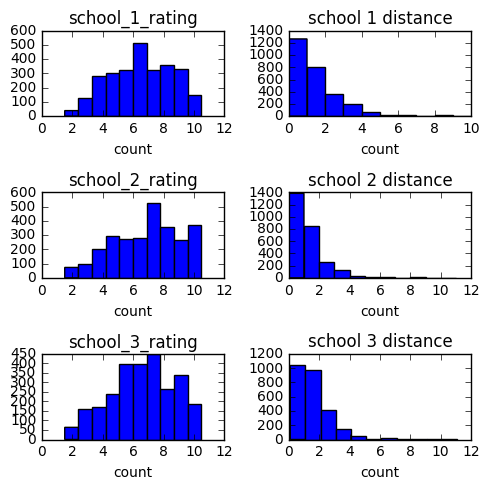

In [12]:
fig, axes = plt.subplots(3,2,figsize=(5,5))

for num, ax in zip(range(1,4), axes):
    field = "school_{}_rating".format(num)
    data = df_filtered[field].dropna() + 0.5
    
    ax[0].hist(data)
    ax[0].set_title(field)
    ax[0].set_xlabel("miles")
    ax[0].set_xlabel("count")

    field = "school_{}_distance".format(num)
    data = df_filtered[field].dropna()
    bin_width = 1
    bins = np.arange(data.min(), data.max() + bin_width, bin_width)
    ax[1].hist(data,bins=bins)
    ax[1].set_title("school {} distance".format(num))
    ax[1].set_xlabel("grade")
    ax[1].set_xlabel("count")

fig.tight_layout()

In [28]:
print("school_1 is most highly correlated to rent. Let's see the differences " + 
      "between the three types of schools\n")

gb_school_grades = pd.DataFrame()

for num in range(1,4):
    field = "school_{}_grades".format(num)
    gb_temp = df_filtered.groupby(field)[field].count()/float(len(df_filtered)) * 100
    gb_school_grades = pd.concat([gb_school_grades, gb_temp], axis=1)
    gb_school_grades.sort_values(by=field,ascending=False,inplace=True)
    print("{} percentages:\n{}\n".format(field,gb_school_grades[field].iloc[:5]))


school_1 is most highly correlated to rent. Let's see the differences between the three types of schools

school_1_grades percentages:
9-12 & ungraded    37.054545
PK-5 & ungraded     8.145455
K-5 & ungraded      7.745455
PK-4 & ungraded     6.327273
PK-8 & ungraded     5.563636
Name: school_1_grades, dtype: float64

school_2_grades percentages:
6-8 & ungraded     21.854545
K-5 & ungraded     12.290909
5-8 & ungraded      8.363636
PK-5 & ungraded     7.527273
9-12 & ungraded     6.981818
Name: school_2_grades, dtype: float64

school_3_grades percentages:
9-12 & ungraded    43.236364
6-8 & ungraded     19.672727
5-8 & ungraded      5.345455
7-8 & ungraded      4.872727
PK-8 & ungraded     3.600000
Name: school_3_grades, dtype: float64



In [29]:
# Let's extract HS rating

df_filtered["school_hs_rating"] = np.nan

df_filtered["school_hs_rating"] = np.where(df_filtered.school_1_grades.str.contains("12|11"), 
         df_filtered.school_1_rating, 
         df_filtered.school_hs_rating)

df_filtered["school_hs_rating"] = np.where(df_filtered.school_2_grades.str.contains("12|11") & np.isnan(df_filtered.school_hs_rating), 
        df_filtered.school_2_rating,
        df_filtered.school_hs_rating)

df_filtered["school_hs_rating"] = np.where(df_filtered.school_3_grades.str.contains("12|11") & np.isnan(df_filtered.school_hs_rating), 
        df_filtered.school_3_rating,
        df_filtered.school_hs_rating)

There's definetely a relationship between school quality and rent.



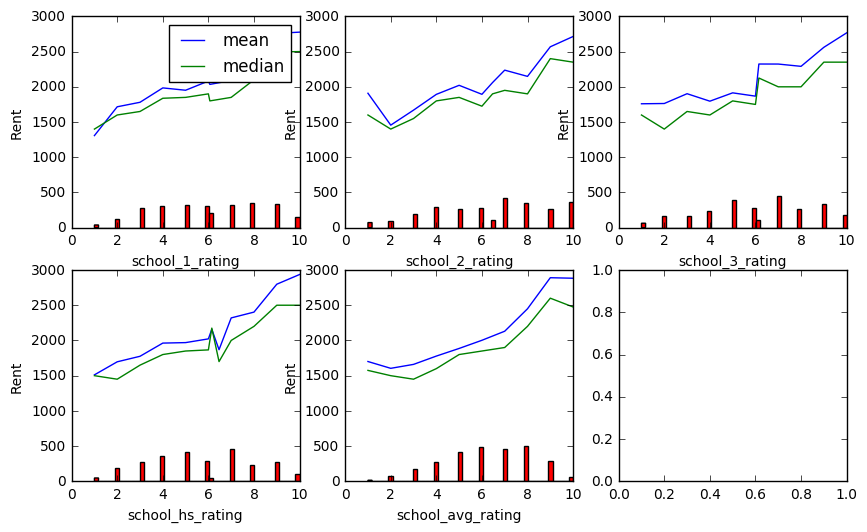

In [30]:
print("There's definetely a relationship between school quality and rent.\n")
df_filtered["school_avg_rating"] = df_filtered[["school_1_rating", "school_2_rating", "school_3_rating"]].mean(axis=1).round()

fig, axes = plt.subplots(2,3,figsize=(10,6))

for num, ax in zip(list(range(1,4))+["hs","avg"], axes.ravel()):
    field = "school_{}_rating".format(num)
    data = df_filtered.groupby(field)["price"]
    ax.plot(data.mean())
    ax.plot(data.median())
    ax.hist(df_filtered[field].dropna(), 50)
    ax.set_ylabel("Rent")
    ax.set_xlabel(field)
    np.corrcoef
    

axes[0][0].legend(["mean", "median"])

In [31]:
print("And see if there's any correlation between the three types of schools\n")
df_filtered[["school_1_rating","school_2_rating","school_3_rating","school_hs_rating","value_est","beds","baths", "price"]].corr()

And see if there's any correlation between the three types of schools



,school_1_rating,school_2_rating,school_3_rating,school_hs_rating,value_est,beds,baths,price
school_1_rating,1.000000,0.576648,0.528138,0.739435,0.311321,0.057776,0.168626,0.293150
school_2_rating,0.576648,1.000000,0.531556,0.671079,0.259168,0.029046,0.190416,0.291746
school_3_rating,0.528138,0.531556,1.000000,0.763835,0.266771,0.053800,0.176429,0.272966
school_hs_rating,0.739435,0.671079,0.763835,1.000000,0.304270,0.084630,0.214574,0.318932
value_est,0.311321,0.259168,0.266771,0.304270,1.000000,0.367798,0.425476,0.712942
beds,0.057776,0.029046,0.053800,0.084630,0.367798,1.000000,0.629044,0.458673
baths,0.168626,0.190416,0.176429,0.214574,0.425476,0.629044,1.000000,0.572996
price,0.293150,0.291746,0.272966,0.318932,0.712942,0.458673,0.572996,1.000000


## Schools as a proxy for location

School rating seems to have a relation to rental value. There is a small relationship between the rating of the school and the number of beds/baths but it is insignificant. School 1 has the most consistent relationship. As school 1 tends to be mostly 9-12, this makes sense since high school quality is likely a high driver in the valuation of a home. Although school ratings are not very highly correlated. Our models will almost certainly work better if we use school rating as a proxy and this will allow us to use linear models

In [32]:
X = df_filtered[["beds", "baths", "value_est","school_hs_rating", "sqft"]]
X = X.fillna(X.mean()) # Some school ratings are missing

y = df_filtered["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Using ['beds' 'baths' 'value_est' 'school_hs_rating' 'sqft'] does not improve our original n_neighbors model based on zipcodes
Best test result score is 0.4835857413076017 at 101 neighbors


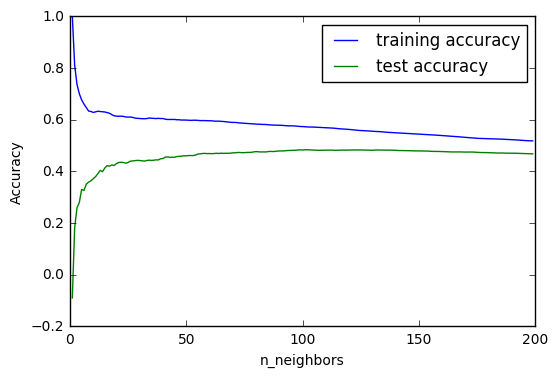

In [33]:
print("Using {} does not improve our original n_neighbors model based on zipcodes".format(
        X_train.columns.values))

results = test_neighbors(range(1,200), X_train, y_train, X_test, y_test)
print("Best test result score is {} at {} neighbors".format(
        max(results["test"]),results["test"].index(max(results["test"]))))

## Linear Models

In [34]:
def print_results(model, X_train, y_train, X_test, y_test, num_coefs=None):
    """ Prints the score on a train and test data set, as well as top num_coefs coefficients"""
    print(model.__class__)
    print("Train score: {}".format(model.score(X_train, y_train)))
    print("Test score: {}\n".format(model.score(X_test, y_test)))
    
    if hasattr(model, "coef_"):
        coefs = zip(X_train.columns, model.coef_)
        coefs = sorted(coefs, key=lambda x: abs(x[1]), reverse=True)

        print("Top {} coefficients".format(num_coefs))
        for col, coef in  coefs[:num_coefs]:
            print(col, "{:0.4f}".format(coef))

In [35]:
print("Let's try a simple linear regression\n")

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
print_results(reg, X_train, y_train, X_test, y_test)

Let's try a simple linear regression

<class 'sklearn.linear_model.base.LinearRegression'>
Train score: 0.6246336969672697
Test score: 0.5940715198010964

Top None coefficients
baths 318.0555
beds 57.2887
school_hs_rating 42.2453
sqft 0.0845
value_est 0.0017


/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [36]:
print("Let's try and add some more variables. " + 
      "We can add powers of the features for a slightly better result\n")

def create_more_exponential(amts, X):
    X_more = X.copy()
    cols = X_more.columns

    for amt in amts:
        for col in cols:
            field = "{}_{}".format(col,amt)
            X_more[field] = X_more[col] ** amt
    return X_more

X_more = create_more_exponential((0.5, 2), X)
X_more_train, X_more_test, y_train, y_test = train_test_split(X_more, y, random_state=42)

reg_more = LinearRegression().fit(X_more_train, y_train)
print_results(reg_more, X_more_train, y_train, X_more_test, y_test)

Let's try and add some more variables. We can add powers of the features for a slightly better result

<class 'sklearn.linear_model.base.LinearRegression'>
Train score: 0.6717890657290279
Test score: 0.5960792889953705

Top None coefficients
school_hs_rating_0.5 1139.3998
beds_0.5 -1087.0677
beds 837.9277
baths_0.5 -819.1938
baths 558.6019
school_hs_rating -385.2457
beds_2 -65.7951
baths_2 19.9009
school_hs_rating_2 13.7787
sqft_0.5 -2.9982
value_est_0.5 -0.1572
sqft -0.0047
value_est 0.0030
sqft_2 0.0000
value_est_2 -0.0000


In [37]:
print("We can also try multiples of the factors however that seems to overfit\n")

X_products = X.copy()

for col1 in X.columns:
    for col2 in X.columns:
        if col1 == col2:
            continue
        field = "{}_x_{}".format(col1, col2)
        X_products[field] = X_products[col1] * X_products[col2]

X_products_train, X_products_test, y_train, y_test = train_test_split(X_products, y, random_state=42)
reg_products = LinearRegression().fit(X_products_train, y_train)

print_results(reg_products, X_products_train, y_train, X_products_test, y_test)

We can also try multiples of the factors however that seems to overfit

<class 'sklearn.linear_model.base.LinearRegression'>
Train score: 0.6363929102098881
Test score: 0.5882172952442574

Top None coefficients
beds 204.3267
baths 139.1069
school_hs_rating 45.4507
beds_x_baths 8.9045
baths_x_beds 8.9045
beds_x_school_hs_rating -5.1156
school_hs_rating_x_beds -5.1156
school_hs_rating_x_baths 0.5384
baths_x_school_hs_rating 0.5384
beds_x_sqft -0.0125
sqft_x_beds -0.0125
school_hs_rating_x_sqft 0.0104
sqft_x_school_hs_rating 0.0104
baths_x_sqft 0.0030
sqft_x_baths 0.0030
value_est 0.0016
sqft -0.0011
baths_x_value_est 0.0001
value_est_x_baths 0.0001
beds_x_value_est -0.0001
value_est_x_beds -0.0001
sqft_x_value_est 0.0000
value_est_x_sqft -0.0000
school_hs_rating_x_value_est -0.0000
value_est_x_school_hs_rating -0.0000


In [112]:
print("Let's go back to adding more columns since that worked well and we didn't overfit. " +
      "However, we seem to cap off at ~64% score on our test set\n")

from itertools import permutations

two_pairs = list(permutations([i * 0.25 for i in range(1,13) if i != 4], 2))
three_pairs = list(permutations([i * 0.25 for i in range(1,13) if i != 4], 3))
pairs = two_pairs + three_pairs

results = {}

for amts in pairs:
    X_more = create_more_exponential(amts, X)    
    X_more_train, X_more_test, y_train, y_test = train_test_split(X_more, y, random_state=42)
    
    reg_more = LinearRegression().fit(X_more_train, y_train)
    train_result = reg_more.score(X_more_train, y_train)
    test_result = reg_more.score(X_more_test, y_test)
    
    results["train"] = results.get("train", []) + [train_result]
    results["test"] = results.get("test", []) + [test_result]

pairs_results = pd.DataFrame(results, index=pairs)
pairs_results.sort_values("test", inplace=True, ascending=False)

print(pairs_results.iloc[:10])

Let's go back to adding more columns since that worked well and we didn't overfit. However, we seem to cap off at ~64% score on our test set

                       test     train
(0.5, 2.5, 2.25)   0.718913  0.642399
(2.0, 2.5, 0.25)   0.716642  0.644798
(2.5, 0.75, 2.0)   0.715822  0.643805
(2.5, 2.0, 0.75)   0.714999  0.643940
(0.25, 2.0, 2.5)   0.714565  0.645445
(2.25, 0.75, 2.0)  0.714523  0.647614
(2.25, 2.5, 0.25)  0.714353  0.645025
(2.5, 2.25, 0.25)  0.713706  0.645110
(2.0, 0.25, 2.5)   0.713532  0.645603
(0.75, 2.5, 2.0)   0.713409  0.644098


### Other Linear Models

Since we're not really overfitting and some of our coefficients are large, Ridge and Lasso will likely give us similar results to the regular linear regression

In [47]:
from sklearn import preprocessing

# Scalers...

scaler_standard_X = preprocessing.StandardScaler().fit(X_train)
X_standard_train = scaler_standard_X.transform(X_train)
X_standard_test = scaler_standard_X.transform(X_test)

scaler_standard_y = preprocessing.StandardScaler().fit(y_train.astype(np.float64).values.reshape(-1,1)) 
y_standard_train = scaler_standard_y.transform(y_train.astype(np.float64).values.reshape(-1,1)).reshape(-1,)
y_standard_test = scaler_standard_y.transform(y_test.astype(np.float64).values.reshape(-1,1)).reshape(-1,)

scaler_standard_X = preprocessing.StandardScaler().fit(X_train)
X_standard_train = scaler_standard_X.transform(X_train)
X_standard_test = scaler_standard_X.transform(X_test)

scaler_minmax_X = preprocessing.MinMaxScaler().fit(X_train) 
X_minmax_train = scaler_minmax_X.transform(X_train)
X_minmax_test = scaler_minmax_X.transform(X_test)

scaler_minmax_y = preprocessing.MinMaxScaler().fit(y_train.astype(np.float64).values.reshape(-1,1))
y_minmax_train = scaler_minmax_y.transform(y_train.astype(np.float64).values.reshape(-1,1)).reshape(-1,)
y_minmax_test = scaler_minmax_y.transform(y_test.astype(np.float64).values.reshape(-1,1)).reshape(-1,)

scaler_minmax_more_X = preprocessing.MinMaxScaler().fit(X_more_train)
X_minmax_more_train = scaler_minmax_more_X.transform(X_more_train)
X_minmax_more_test = scaler_minmax_more_X.transform(X_more_test)

In [48]:
from sklearn.svm import SVR

print("SVR is doing similarly to our linear regression\n")

for C in np.linspace(100, 500, 17):
    svr = SVR(C=C).fit(X_minmax_train, y_minmax_train)
    svr_more = SVR(C=C).fit(X_minmax_more_train, y_minmax_train)
    print("C={} train:{:.2f}\ttest:{:.2f} \tmore train:{:.2f} \tmore test:{:.2f}".format(
        C, 
        svr.score(X_minmax_train, y_minmax_train), 
        svr.score(X_minmax_test, y_minmax_test),
        svr_more.score(X_minmax_more_train, y_minmax_train),
        svr_more.score(X_minmax_more_test, y_minmax_test)
    ))

SVR is doing similarly to our linear regression

C=100.0 train:0.63	test:0.55 	more train:0.65 	more test:0.53
C=125.0 train:0.64	test:0.55 	more train:0.65 	more test:0.53
C=150.0 train:0.64	test:0.56 	more train:0.65 	more test:0.54
C=175.0 train:0.64	test:0.56 	more train:0.65 	more test:0.54
C=200.0 train:0.64	test:0.55 	more train:0.66 	more test:0.54
C=225.0 train:0.64	test:0.56 	more train:0.66 	more test:0.54
C=250.0 train:0.64	test:0.55 	more train:0.66 	more test:0.53
C=275.0 train:0.64	test:0.55 	more train:0.66 	more test:0.53
C=300.0 train:0.64	test:0.55 	more train:0.66 	more test:0.53
C=325.0 train:0.64	test:0.55 	more train:0.66 	more test:0.53
C=350.0 train:0.64	test:0.56 	more train:0.66 	more test:0.53
C=375.0 train:0.64	test:0.55 	more train:0.66 	more test:0.52
C=400.0 train:0.64	test:0.55 	more train:0.66 	more test:0.52
C=425.0 train:0.64	test:0.55 	more train:0.66 	more test:0.52
C=450.0 train:0.64	test:0.55 	more train:0.66 	more test:0.52
C=475.0 train:0.64	te

In [49]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)

print("RandomForestRegressor from the box scores higher than our best linear regression\n")
print_results(rf, X_train, y_train, X_test, y_test)

RandomForestRegressor from the box scores higher than our best linear regression

<class 'sklearn.ensemble.forest.RandomForestRegressor'>
Train score: 0.9246437644558804
Test score: 0.5766455255659277



In [50]:
print("Results based on how many features are used in the tree. " +
      "Pretty consistent scores around h50/l90s for test/train data\n")

results = {}
max_features = range(1,len(X.columns))

for num in max_features:
    rf = RandomForestRegressor(random_state=42, max_features=num).fit(X_train, y_train)
    results["train"] = results.get("train", []) + [rf.score(X_train, y_train)]
    results["test"] = results.get("test", []) + [rf.score(X_test, y_test)]
    
    rf_more = RandomForestRegressor(random_state=42, max_features=num).fit(X_more_train, y_train)
    results["train_more"] = results.get("train_more", []) + [rf_more.score(X_more_train, y_train)]
    results["test_more"] = results.get("test_more", []) + [rf_more.score(X_more_test, y_test)]

max_features_results = pd.DataFrame(results, index=max_features)
max_features_results.sort_values("test", inplace=True, ascending=False)
print(max_features_results.iloc[:5])

Results based on how many features are used in the tree. Pretty consistent scores around h50/l90s for test/train data

       test  test_more     train  train_more
3  0.601020   0.606442  0.927398    0.922636
5  0.595089   0.572090  0.924613    0.926461
2  0.583807   0.571815  0.923201    0.923640
4  0.579446   0.574240  0.923870    0.925708
6  0.569108   0.575929  0.926243    0.923111


In [51]:
print("Results by varying max_depth are also pretty consistent.\n")

results = {}
max_depth = range(1,20)

for num in max_depth:
    rf = RandomForestRegressor(random_state=42, max_depth=num).fit(X_train, y_train)
    results["train"] = results.get("train", []) + [rf.score(X_train, y_train)]
    results["test"] = results.get("test", []) + [rf.score(X_test, y_test)]

    rf_more = RandomForestRegressor(random_state=42, max_depth=num).fit(X_more_train, y_train)
    results["train_more"] = results.get("train_more", []) + [rf_more.score(X_more_train, y_train)]
    results["test_more"] = results.get("test_more", []) + [rf_more.score(X_more_test, y_test)]

max_depth_results = pd.DataFrame(results, index=max_depth)
max_depth_results.sort_values("test", inplace=True, ascending=False)
print(max_depth_results.iloc[:5])

Results by varying max_depth are also pretty consistent.

        test  test_more     train  train_more
7   0.611993   0.610279  0.805407    0.804749
6   0.611939   0.602376  0.777592    0.779157
8   0.602532   0.599019  0.839135    0.837073
5   0.601058   0.600845  0.736692    0.736444
10  0.599325   0.598890  0.879699    0.878708


In [52]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    """Visualizes a tree"""
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

Let's see what one of these trees actually looks like. The trees that have been performing the best are too complicated to visualize, but lets use a simpler treewith a small max_depth. The tree looks in line with what we would expect (positive  relationship to baths, sqft and school ratings)



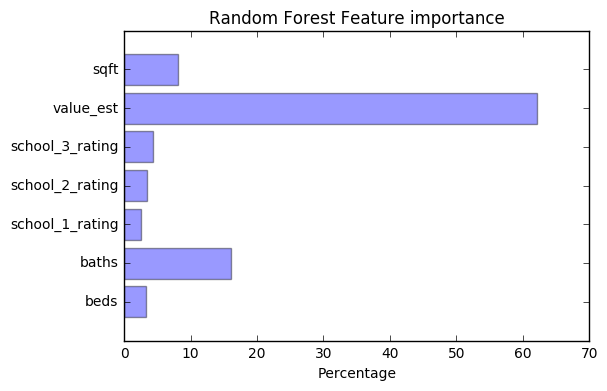

Simple RandomForest with max_depth of 3

<class 'sklearn.ensemble.forest.RandomForestRegressor'>
Train score: 0.6567908098454083
Test score: 0.5665025143988833

def tree(beds, baths, school_1_rating, school_2_rating, school_3_rating, value_est, sqft):
  if value_est <= 732692.0:
    if value_est <= 250535.5:
      if baths <= 1.25:
        return [[ 1333.17055655]]
      else:  # if baths > 1.25
        return [[ 1736.14420063]]
    else:  # if value_est > 250535.5
      if baths <= 1.25:
        return [[ 1736.84946237]]
      else:  # if baths > 1.25
        return [[ 2495.3346815]]
  else:  # if value_est > 732692.0
    if value_est <= 1029466.0:
      if beds <= 2.5:
        return [[ 2102.77777778]]
      else:  # if beds > 2.5
        return [[ 3829.14141414]]
    else:  # if value_est > 1029466.0
      if baths <= 3.25:
        return [[ 4213.97058824]]
      else:  # if baths > 3.25
        return [[ 6333.33333333]]


In [53]:
print("Let's see what one of these trees actually looks like. The trees that have been " +
    "performing the best are too complicated to visualize, but lets use a simpler tree" +
     "with a small max_depth. The tree looks in line with what we would expect (positive " +
      " relationship to baths, sqft and school ratings)\n")

rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
y_pos = range(len(rf.feature_importances_))
plt.barh(y_pos, rf.feature_importances_ * 100, align='center', alpha=0.4)
plt.yticks(y_pos, X_train.columns)
plt.xlabel("Percentage")
plt.title("Random Forest Feature importance")
plt.show()

print("Simple RandomForest with max_depth of 3\n")
rf_simple = RandomForestRegressor(max_depth=3).fit(X_train, y_train)
print_results(rf_simple, X_train, y_train, X_test, y_test)

tree_to_code(rf_simple.estimators_[0], X_train.columns)

## Neural Networks

In [46]:
from sklearn.neural_network import MLPRegressor

print("Not bad right out of the box...\n")

mlp = MLPRegressor(random_state=42).fit(X_standard_train, y_standard_train)
print_results(mlp, X_standard_train, y_standard_train, X_standard_test, y_standard_test)

Not bad right out of the box...

<class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>
Train score: 0.6863958062832414
Test score: 0.6010415599652578



In [47]:
print("Let's try to mess with number of hidden layers and their sizes but it looks like " + 
     "its not making much of a difference")

results = {}

for layer_size in map(int, np.linspace(50,250,5)):
    layer_results = []
    for num_layers in range(1,6):
        hidden_layer_sizes = [layer_size for _ in range(num_layers)]
        mlp = MLPRegressor(random_state=42, hidden_layer_sizes=hidden_layer_sizes).fit(X_standard_train, y_standard_train)
        layer_results.append("train: {:.4f} test: {:.4f}".format(
                mlp.score(X_standard_train, y_standard_train), 
                mlp.score(X_standard_test, y_standard_test)))
    results[layer_size] = layer_results

results_df = pd.DataFrame(results,index=range(1,6))
results_df.index.name="Num Layers"
results_df.columns.name="Layer size"
results_df

Let's try to mess with number of hidden layers and their sizes but it looks like its not making much of a difference


Layer size,50,100,150,200,250
Num Layers,,,,,
1,train: 0.6879 test: 0.6021,train: 0.6864 test: 0.6010,train: 0.6936 test: 0.6024,train: 0.6962 test: 0.6089,train: 0.6898 test: 0.6050
2,train: 0.7237 test: 0.6160,train: 0.7159 test: 0.6074,train: 0.7421 test: 0.6086,train: 0.6903 test: 0.6018,train: 0.6881 test: 0.5948
3,train: 0.7321 test: 0.5944,train: 0.7129 test: 0.5870,train: 0.7197 test: 0.6024,train: 0.7095 test: 0.5952,train: 0.7699 test: 0.5954
4,train: 0.7332 test: 0.5823,train: 0.7868 test: 0.6024,train: 0.7504 test: 0.6010,train: 0.7528 test: 0.5884,train: 0.7662 test: 0.5929
5,train: 0.7501 test: 0.5921,train: 0.7900 test: 0.5630,train: 0.7692 test: 0.5864,train: 0.7892 test: 0.5765,train: 0.6956 test: 0.5871


In [95]:
print("We can try to add more parameters such as sqrt and square of the paramenters, " + 
      "but the results are very similar\n")

X_more = create_more_exponential((0.5, 2), X)
X_more_train, X_more_test, y_more_train, y_more_test = train_test_split(X_more, y, random_state=42)

mlp_more = MLPRegressor(random_state=42,hidden_layer_sizes=(100,)).fit(X_standard_train, y_standard_train )
print_results(mlp_more, X_standard_train, y_standard_train, X_standard_test, y_standard_test)

We can try to add more parameters such as sqrt and square of the paramenters, but the results are very similar



NameError: name 'create_more_exponential' is not defined

## Choosing a Model

The strongest models so far are neural networks and Random Forest Regressors at 0.7 score for the test data. The benefit of using the Random Forest is that it is more transparent and easier to explain. However, a hybrid model of the two could do better, especially if the two models are making different types of errors

In [5]:
from models import HybridModel

rf = RandomForestRegressor(max_depth=13, max_features=3,random_state=42).fit(X_train, y_train)
mlp = MLPRegressor(random_state=42).fit(X_standard_train, y_standard_train)

hybrid = HybridModel.HybridModel()
hybrid.add_model(RandomForestRegressor(max_depth=rf.max_depth, max_features=rf.max_features,random_state=rf.random_state))
hybrid.add_model(MLPRegressor(random_state=42), scaler_X=scaler_standard_X, scaler_y=scaler_standard_y)
                 
hybrid.fit(X_train, y_train)

print("Our hybrid model that takes an average of the models input as the prediction seems to " +
      "outperform either model.")

print(("RandomForest score train: {:.4f} test: {:.4f}\n"
      "MLPerceptron score train {:.4f} test: {:.4f}\n" +
      "Hybrid score train: {:.4f} test: {:.4f}").format(
        hybrid.models[0].score(X_train, y_train), hybrid.models[0].score(X_test, y_test),
        hybrid.models[1].score(X_standard_train, y_standard_train), hybrid.models[1].score(X_standard_test, y_standard_test),
        hybrid.score(X_train, y_train), hybrid.score(X_test, y_test))
    )

NameError: name 'RandomForestRegressor' is not defined

## Error Analysis

Errors have a long negative tail, suggesting that most of the model errors are due to predicting a rent higher than the actual rent. In other words, something may be wrong with the property. Also, when compared to zestimes for rent, our model performes better with the exception of zestimates with a zero error. This suggests that the rent-zestimate uses the rent price as a factor while our model does not consider the actual rent price since that is the field its trying to predict.




,price,zes_price,hybrid_price,zes_diff,zes_perc_diff,hybrid_diff,hybrid_perc_diff
count,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000
mean,2144.799732,2201.603818,2144.835797,-56.804086,-0.057427,-0.036065,-0.043153
std,1058.827944,1265.306590,880.027892,833.799512,0.335545,486.671071,0.214656
min,400.000000,730.000000,780.463481,-12047.000000,-7.000000,-2790.440438,-3.208917
25%,1500.000000,1600.000000,1572.012755,-100.000000,-0.067380,-165.073372,-0.096663
50%,1900.000000,1900.000000,1928.242927,0.000000,0.000000,-17.506631,-0.009529
75%,2500.000000,2400.000000,2472.480013,100.000000,0.043478,137.453140,0.064489
max,9700.000000,18047.000000,7783.475077,6220.000000,0.884058,6314.266202,0.762302


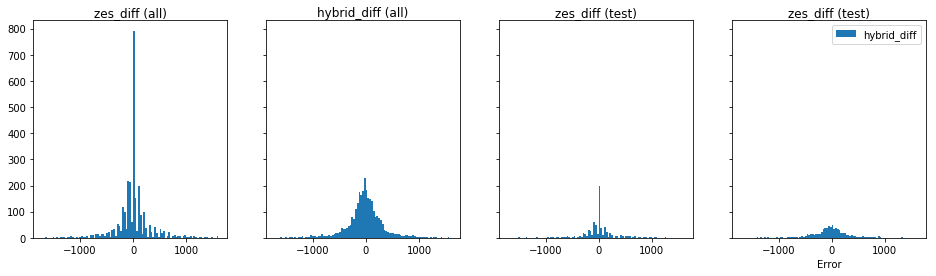

Percentage of rent-zestimates with zero errors to listed rent: 24.28%



In [1097]:
print("Errors have a long negative tail, suggesting that most of the model errors " +
      "are due to predicting a rent higher than the actual rent. In other words, " +
     "something may be wrong with the property. Also, when compared to zestimes "  +
     "for rent, our model performes better with the exception of zestimates with " + 
     "a zero error. This suggests that the rent-zestimate uses the rent price as " +
     "a factor while our model does not consider the actual rent price since that " +
      "is the field its trying to predict.\n\n")
      
from IPython.display import display

# df_test = df_filtered.loc[X_test.index]

actual_price = pd.DataFrame(df_filtered.loc[X.index][["price"]], index=X.index)

zes_price = df_filtered.loc[X.index][["rent_est"]]
zes_price.columns = ["zes_price"]
hybrid_price = pd.DataFrame(hybrid.predict(X),index=X.index, columns=["hybrid_price"])

df_errors = pd.concat([actual_price, zes_price, hybrid_price],axis=1)

for price_type in df_errors.columns:
    if price_type == "price":
        continue
    price_diff = df_errors["price"] - df_errors[price_type]
    price_diff_perc = price_diff / df_errors["price"]
    
    price_diff_col = price_type.replace("_price","_diff")
    price_diff_perc_col = price_type.replace("_price","_perc_diff")
    
    df_errors[price_diff_col] = price_diff
    df_errors[price_diff_perc_col] = price_diff_perc

df_errors.describe()

results_zes_comp = df_errors[~df_errors["zes_price"].isnull()]
results_zes_comp = results_zes_comp[[col for col in df_errors.columns if "diff" in col or "price" in col]]

display(results_zes_comp.describe())

zes_error_mean = int(results_zes_comp.zes_diff.mean())
zes_error_std = int(results_zes_comp.zes_diff.std())

bins = np.linspace(zes_error_mean - (2 * zes_error_std), zes_error_mean + (2 * zes_error_std), 100)

fig, axes = plt.subplots(1,4, figsize=(16,4),sharey=True)

axes[0].hist(results_zes_comp["zes_diff"], bins)
axes[0].set_title("zes_diff (all)")

axes[1].hist(results_zes_comp["hybrid_diff"], bins)
axes[1].set_title("hybrid_diff (all)")

axes[2].hist(results_zes_comp[results_zes_comp.index.isin(X_test.index)]["zes_diff"], bins)
axes[2].set_title("zes_diff (test)")

axes[3].hist(results_zes_comp[results_zes_comp.index.isin(X_test.index)]["hybrid_diff"], bins)
axes[3].set_title("zes_diff (test)")

plt.xlabel("Error")

plt.legend()
plt.show()

print("Percentage of rent-zestimates with zero errors to listed rent: {:.2f}%\n".format(
    len(results_zes_comp.zes_diff[results_zes_comp.zes_diff == 0]) / float(len(results_zes_comp)) * 100))


Our errors have a long left tail, regardless of how many bedrooms. But errors are more pronounced on the smaller units. Also, the zestimate on those the model is making the greatest errors on isn't necessarily very low, otherwise, the model would have used that fact


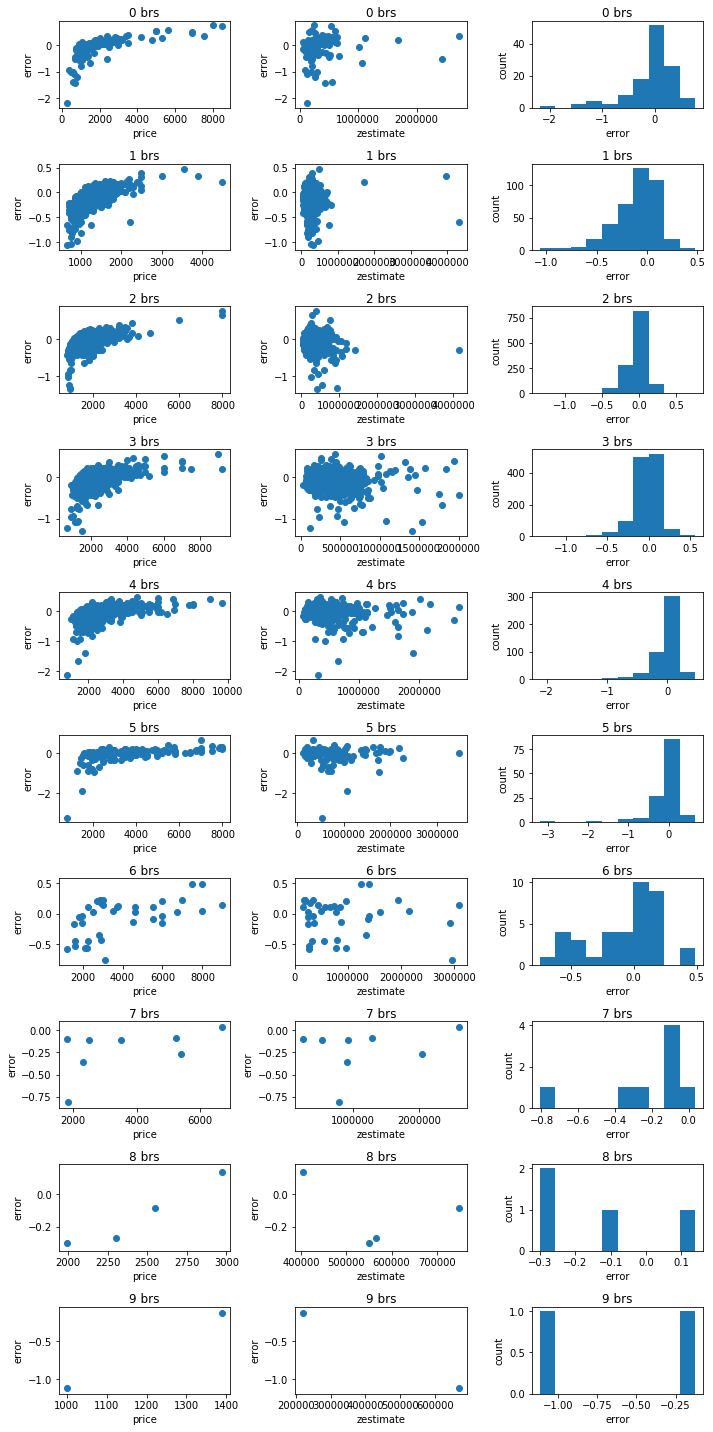

In [1098]:
print ("Our errors have a long left tail, regardless of how many bedrooms. But errors " + 
      "are more pronounced on the smaller units. Also, the zestimate on those the model " + 
      "is making the greatest errors on isn't necessarily very low, otherwise, the model " +
      "would have used that fact")

df_filtered_errors = pd.concat([df_filtered, df_errors.drop("price",axis=1)], axis=1, join="inner")

brs = sorted(df_filtered_errors.beds.unique())
fig, axes = plt.subplots(len(brs),3,figsize=(10, 20))


for ax, br in zip(axes, brs):
    df_filtered_errors_br = df_filtered_errors[df_filtered_errors["beds"] == br]
    ax[0].scatter(df_filtered_errors_br["price"], df_filtered_errors_br["hybrid_perc_diff"])
    ax[0].set_xlabel("price")
    ax[0].set_ylabel("error")
    ax[0].set_title("{} brs".format(br))

    ax[1].scatter(df_filtered_errors_br["value_est"], df_filtered_errors_br["hybrid_perc_diff"])
    ax[1].set_xlabel("zestimate")
    ax[1].set_ylabel("error")
    ax[1].set_title("{} brs".format(br))
    
    ax[2].hist(df_filtered_errors_br["hybrid_perc_diff"])
    ax[2].set_xlabel("error")
    ax[2].set_ylabel("count")
    ax[2].set_title("{} brs".format(br))
    
fig.tight_layout()


In [1313]:
print("It appears as some zipcodes have higher errors that other. The makes sense as " + 
     "some areas are very undesirable to live in and this isn't encapsulated well " +
     "enough in the school ratings. We can look at adding new fields to identify" +
     "(un)desirable places to live that should (decrease)increase the rent")

# create absolute values of differences for each error
diff_cols = [col for col in df_errors.columns if "_diff" in col and "_abs" not in col]

for col in diff_cols:
    abs_diff_call = "{}_abs_diff".format(col.replace("_diff",""))
    df_filtered_errors[abs_diff_call] = df_errors[col].abs()

def filter_df_by_count(df, field, count):
    """ Returns dataframe whose records have a 'field' that is represented at least 'count' times  
    e.g.
        >> df = pd.DataFrame({"A": [1,2,1], "B": [3,4,2]})
        >> filter_df_by_count(df, "A", 2)
        A B
        1 3
        1 2
    """
    return df.groupby(field).filter(lambda x: len(x) >= count)

def pivot(df, group_by_fields, agg_fields, aggs, sort_by=None, ascending=False):
    """ Returns a pivot of a dataframe with 'fields' and 'agg' aggregated fields
    e.g.
        >> df = pd.DataFrame({"A": [1,2,1], "B": [3,4,2]})
        >> pivot(pd.DataFrame(df, "A", ["B"], ["mean", "count"])
        A B
          mean count
        1 2.5  2
        2 4.0  1
    """
    df_pivoted = df.groupby(group_by_fields)[agg_fields].agg(aggs)
    if "count" in aggs:
        df_pivoted.drop("count", level=1, axis=1, inplace=True)
        df_counts = df.groupby(group_by_fields).size().rename("Count")
        df_pivoted = pd.concat([df_counts, df_pivoted], axis=1)
        
    if sort_by is not None:
        return df_pivoted.sort_values(by=sort_by, ascending=ascending)
 
    return df_pivoted
    

df_common_zipcodes = filter_df_by_count(df_filtered_errors, "zipcode", 5)
df_common_zipcodes = pivot(df_common_zipcodes, 
                           "zipcode", 
                           ["hybrid_perc_abs_diff","hybrid_perc_diff","hybrid_diff"], 
                           ["mean", "count"], 
                           sort_by=[("hybrid_perc_abs_diff", "mean")])
df_common_zipcodes.iloc[:10]

It appears as some zipcodes have higher errors that other. The makes sense as some areas are very undesirable to live in and this isn't encapsulated well enough in the school ratings. We can look at adding new fields to identify(un)desirable places to live that should (decrease)increase the rent


,Count,"(hybrid_perc_abs_diff, mean)","(hybrid_perc_diff, mean)","(hybrid_diff, mean)"
zipcode,,,,
08402,51,0.646037,-0.509676,-115.217992
08750,7,0.493921,-0.387372,-616.594822
07823,7,0.406122,-0.367448,-147.076890
07720,17,0.400895,-0.243012,12.250440
08226,18,0.393052,-0.364327,-434.536885
08078,6,0.354923,0.046531,1145.229239
07762,37,0.332787,-0.169302,-45.572661
08406,14,0.328014,-0.225963,-160.096587
07764,6,0.316074,-0.316074,-691.061485


In [ ]:
df

In [1053]:
print("Let's save the model for use on a new dataset")

import dill

with open('test.pkl', 'wb') as output:
    dill.dump(test, output)


Let's save the model for use on a new dataset


We can look to see if any of the large errors are geographically concentrated. Below graph shows errors based on location with red signifying errors where actual value was 50%+ lower than predicted and green signifying errors where actual value was 50%+ higher than predicted


(<matplotlib.figure.Figure at 0x12c7fc990>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12cb8b190>)

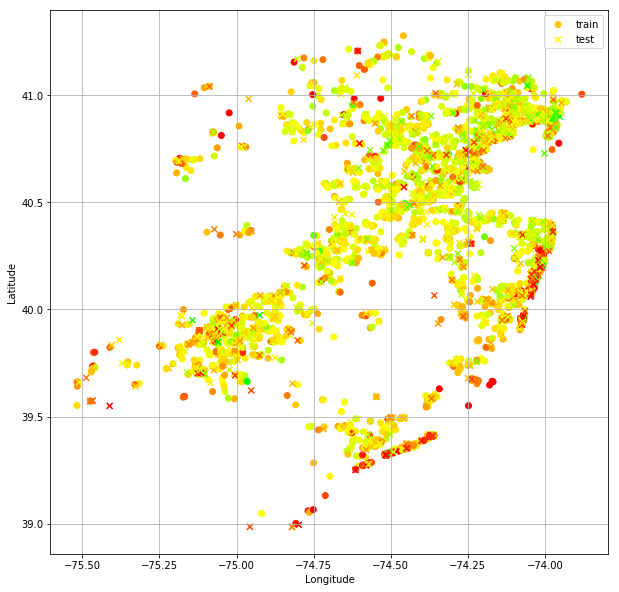

In [1508]:
print("We can look to see if any of the large errors are geographically concentrated. " +
     "Below graph shows errors based on location with red signifying errors where actual " +
     "value was 50%+ lower than predicted and green signifying errors where actual " +
     "value was 50%+ higher than predicted")
from colorsys import hsv_to_rgb

def get_colors(vals, min_val=-1, max_val=1):
    """ Maps values between min_val and max_val to red to green.
        if val is <= min_val, red
        if min_val > val < max_val, shade of yellow
        if val is >= max_val, green
    """
    colors = []

    if not hasattr(vals, '__iter__'):
        vals = [vals]
    for val in vals:
        conv_val = (val - min_val) / float(max_val - min_val)
        h = max(min(120 * conv_val, 120) , 0) / 360.
        rgb = hsv_to_rgb(h,1,1)
        r,g,b = [int(val * 255) for val in rgb]
        colors.append('#{:02X}{:02X}{:02X}'.format(r, g, b))
        
    return colors

def plot_errors(df, error_field, train_index, test_index, min_val=-1, max_val=1):
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    for idx, marker, label in zip([train_index, test_index], ["o","x"], ["train","test"]):
        colors = get_colors(df[df.index.isin(idx)][error_field],min_val=min_val, max_val=max_val)
        ax.scatter(df[df.index.isin(idx)].longitude,
                   df[df.index.isin(idx)].latitude,
                    marker=marker,
                    color=colors,
                    label=label
                   )
    ax.legend()
    ax.grid()
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    return fig, ax

plot_errors(df_filtered_errors,
            "hybrid_perc_diff", 
            X_train.index,
            X_test.index,
            min_val=-.5,
            max_val=.5
           )
    

We can look more closely at a certain area. From the errors, there appears to be geographical locations where our model is consistently over-estimating the rental price.


(<matplotlib.figure.Figure at 0x12ad260d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x130a0f4d0>)

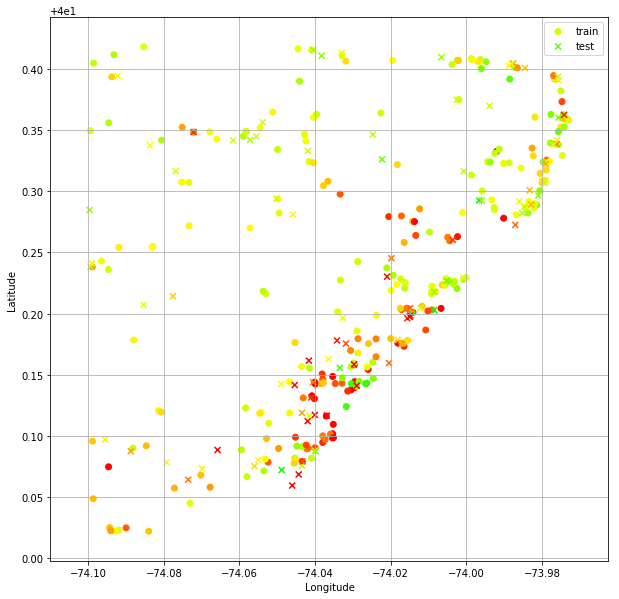

In [1510]:
print("We can look more closely at a certain area. From the errors, there appears to be " + 
     "geographical locations where our model is consistently over-estimating the rental price.")
lat_mask = (df_filtered_errors.longitude > -74.1)
long_mask = (df_filtered_errors.latitude > 40) & (df_filtered_errors.latitude < 40.5)

plot_errors(df_filtered_errors[lat_mask & long_mask],
            "hybrid_perc_diff", 
            X_train.index,
            X_test.index,
            min_val=-.5,
            max_val=.5
           )


## Encapsulating bad/good neighborhoods

In the model we use school ratings as a proxy for quality of neighborhoods. However, there appear to be differences in the neighborhoods that are not fully explained by the school quality causing the large concentrated errors. For those, we should look to create a new field that is determined by the training error. We can then expand that area to encompass other homes with high training errors and use them as a field in our training

In [1230]:
from math import hypot

df_filtered_errors["coords"] = zip(df_filtered_errors.longitude, df_filtered_errors.latitude)

def distance(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    return math.hypot(x2 - x1, y2 - y1)

def find_closest(df, idx, n=None):
    """ Finds the closest n neighbor to index based on coordinates """
    coords = df.loc[idx]["coords"]
    distances = map(lambda x: abs(distance(coords, x)), df["coords"])
    df_new = pd.concat([df, pd.DataFrame(distances, index=df.index, columns=["distance"])],axis=1)
    return df_new.sort_values(by="distance").iloc[:n]


In [1254]:
neighborhoods = {}

# minimum percentage model error required to classify home in neighborhood
# for instance, if differences of -50%, -35% and -25% would be in one neighborhood while
# difference of only -5% would not and therefore break the neighborhood
min_difference = 0.25 

# minimum neighborhood size used to determine neighborhood
min_neighborhood_size = 3

df_filtered_errors_train = df_filtered_errors.loc[X_train.index]

for idx in df_filtered_errors_train.sort_values(by="hybrid_perc_diff").index:
    diff = df_filtered_errors_train.loc[idx]["hybrid_perc_diff"]
    if abs(diff) < min_difference:
        continue
        
    neighbors = find_closest(df_filtered_errors_train, idx)
    neighbors_to_add = set()
    for n_idx in neighbors.index:
        n_diff = neighbors.loc[n_idx]["hybrid_perc_diff"]
        if diff * n_diff < 0:
            # one positive, one negative
            break
        if abs(n_diff) < min_difference:
            # not large enough of a difference
            break
        neighbors_to_add.add(n_idx)
    if len(neighbors_to_add) >= min_neighborhood_size:
        neighborhoods[idx] = neighbors_to_add

In [1266]:
new_neighborhoods = {}
for idx, n_idxes in neighborhoods.iteritems():
    new_neighbors = set()
    for n_idx in n_idxes:
        new_neighbors.add(df_filtered_errors_train.loc[n_idx].coords)
    new_neighborhoods[df_filtered_errors_train.loc[idx].coords] = new_neighbors

In [1532]:
# for min_difference in np.linspace(.1,1,10):
min_difference = 0.4
neighborhoods = pivot(df_filtered_errors_train, ["zipcode"], 
      ["hybrid_perc_diff"], 
      ["mean", "count"])
neighborhoods = neighborhoods[neighborhoods["Count"] >= min_neighborhood_size]
neighborhoods = neighborhoods[neighborhoods[("hybrid_perc_diff", "mean")] <= -min_difference]

X_train_new = pd.concat([X_train, df_filtered.loc[X_train.index]["zipcode"].isin(neighborhoods.index)], axis=1, join="inner")
X_test_new = pd.concat([X_test, df_filtered.loc[X_test.index]["zipcode"].isin(neighborhoods.index)], axis=1, join="inner")
print min_difference, RandomForestRegressor(max_features=3,random_state=42).fit(X_train_new, y_train).score(X_test_new, y_test)

0.4 0.618544426312


In [1543]:

HybridModel.HybridModel().add_model(
    RandomForestRegressor(random_state=42),
).fit(X_train_new, y_train).score(X_test_new, y_test)

0.57345594031852198

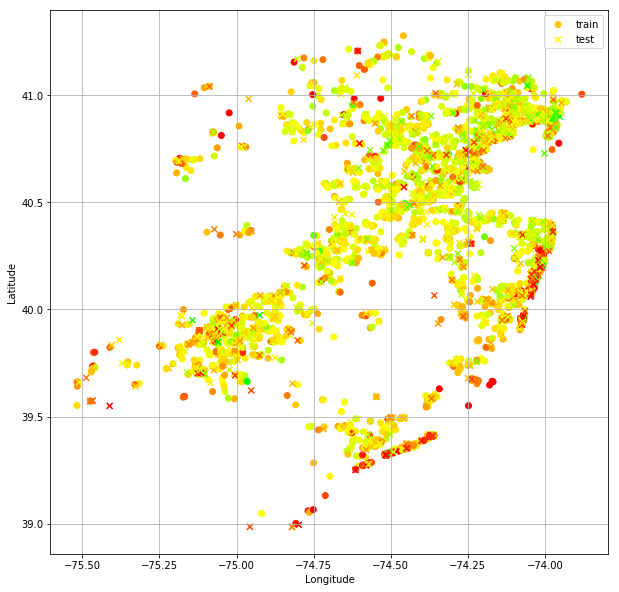

In [1493]:
fig, ax = plot_errors(df_filtered_errors,
            "hybrid_perc_diff", 
            X_train.index,
            X_test.index,
            min_val=-.5,
            max_val=.5
           )
